# Bagging and Random Forests
#### Jack Bennetto
#### Land Belenky

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from scipy.special import comb
from scipy.stats import binom

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer, load_iris


## Objectives


 * Explain the relationship and difference between bagging and a random forest.
 * Explain why bagging/random forests are more accurate than a single decision tree.
 * Explain & construct a random forest (classification or regression).
 * Get feature importances from a random forest.
 * Explain how OOB error is calculated and what it estimates.

## Agenda

 * Discuss ensemble methods
 * Review bias/variance tradeoff
 * Review decision trees
 * Discuss bagging (bootstrap aggregation)
 * Discuss random forests
 * Discuss out-of-bag error
 * Discuss feature importance

## What is an Ensemble Method?

In general, an **ensemble** method combines many weak models to form a strong model. We train multiple models on the data, such that each is different. They could be trained on different subsets of the data, or trained in different ways, or even be completely different types of models.

Once we've done that, we need to combine the models to form a single model.

How would we get a single prediction from an ensemble of **regression** models?

How would we get a single prediction from an ensemble of **classification** models?



## Ensembles: Intuition

Suppose we have 5 *independent* hard binary classifiers (they only give 0 or 1 probability). If they are each  70% accurate, what's the accuracy of an ensemble of them?

The ensemble is correct when 3, 4 or 5 of the predictors are correct. 

$$\large P(Ensemble) =\binom{5}{3} 0.7^3 0.3^2 +\binom{5}{4} 0.7^4 0.3 + \binom{5}{5} 0.7^5 \approx 0.837 $$

### Or we could use scipy.stats:

In [2]:
def ensemble_accuracy(n,p):
    return 1 - binom(n, p).cdf((n-1)//2)

ensemble_accuracy(5,.7)

0.8369199999999999

### As the number of *independent* predictors in our ensemble goes up, the overall accuracy goes up, even though the predictors are not improving

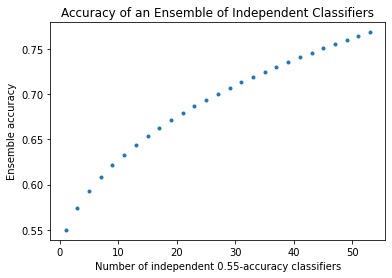

In [3]:
ns = np.arange(1, 55, 2)
vfea = np.vectorize(ensemble_accuracy)
p = .55
ensemble_accuracies = vfea(ns, p=p)

fig, ax = plt.subplots()
ax.plot(ns, ensemble_accuracies, '.')
ax.set_ylabel("Ensemble accuracy")
ax.set_xlabel(f"Number of independent {p}-accuracy classifiers")
ax.set_title("Accuracy of an Ensemble of Independent Classifiers");

#### With 55 such classifiers we can achieve 99.9% accuracy.


**Question:** what's the limitation?

## Important:  They must be *independent*

### If they're not independent, you're just making the same prediction over and over again.

(Side note:  remember when we said yesterday that Decision Trees are *deterministic*)

## How to Make Them Independent?

If the learners are all the same, ensembles don't help.

Train each learner on different subset of data.

**Question:** Why is this better than a single good model?

## Bias and Variance

**Question:** what is bias?

**Question:** what is variance?

**Question:** what is the bias of an unpruned decision tree?

## Review: Classification Trees

A **classification tree** is a decision tree to predict whether a data point is in one class or another. Each branch node is a decision, choosing left or right based on the value of a certain **feature**.

Splits terminate in a leaf node. The data point is predicted to be in the class of the leaf it ultimately arrives in.

### Let's look at the tennis dataset from the other day.

In [4]:
# Read in our data
tennis_df = pd.read_csv('data/tennis.txt', delim_whitespace=True)
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = (tennis_df['played']=='yes')*1
tennis_df

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
6,overcast,cool,normal,True,1
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1


### This is what it looks like as a tree:

![](images/tree.png)

### A classification tree is built by

* Consider **every** possible split of **every** feature at **every** value
* Pick the **one** split that provides the best information gain (reduction in entropy/gini impurity)
* Discard the other splits.
* Use that split to create two new nodes and consider splitting them on every possible feature/value.
* Stop when all nodes are pure or other stopping conditions like depth limit are met
* Prune trees by merging nodes (ie., canceling a split)

## A few things to notice:
* Any node that does not get split further is a leaf node
* Leaf nodes can appear at any level on the tree
* After being split from a parent, sibling nodes are independent. They don't have to be split on the same feature 
* Multi-class or numeric features can be split many times and don't have to be in any order or follow any direction
* Splits are totally independent of each other. If a split on one branch says $$X_i>50 \rightarrow Class A$$ a split on another branch might say $$X_i>50 \rightarrow Class B$$ and a subsequent split on the same branch might say $$X_i > 52 \rightarrow \text{Class A or Class B}$$  I.E, the first split does nothing to bias or predispose any other split


## Review: Regression Trees

A **regression tree** predicts a number rather than the class.

Prediction works the same as with classification trees, but the leaf nodes give a number rather than probabilities of a class.

To train a regression tree, we

* Iteratively divide the nodes such that *total squared error* is minimized,

$$\Large \text{Total Sqaured Error} = \sum_{i \in Left} (y_i - \mu_L)^2 + \sum_{i\in Right} (y_i - \mu_R)^2$$

There are other metrics, but they all pretty much do the same thing, which is to the difference between *actual* and *predicted*.

* Use various stopping conditions like a depth limit, minimum leaf size, and
* Prune trees by merging nodes (or canceling splits)

## Regression Trees: Example

 x_1 |   x_2 |  y
-------|---------|--------
 1     |    1    |   1
 0     |    0    |   2
 1     |    0    |   3
 0     |    1    |   4

 Prior to the split we use the mean, ($\mu = 2.5$), as the prediction for everything, giving total squared error:
 
 $$\large E_{parent} = \sum \left(y_i - \mu_{parent} \right)^2$$
 
 $$\large E_{parent} = (1-2.5)^2 + (2-2.5)^2 + (3-2.5)^2 + (4-2.5)^2$$
 
 
 $$\large E_{parent} = 5 $$
 
 After we split on $x_1$, rows 1 & 3 have a mean value of 2, and rows 2 & 4 have a mean value of 3:
 
 $$\large E_{children} = E_{\text{left child}} + E_{\text {right child}}$$
 
 $$\large E_{children} = \sum_{left}(y_i - \mu_{left})^2 + \sum_{right}(y_j - \mu_{right})^2$$
 
 $$\large E = (1-2)^2 + (3-2)^2 + (2-3)^2 + (4-3)^2 = 4 $$
 
 The information gain is:
 
 $$\large E_{parent} - E_{children} = 5 - 4 = 1$$
 
 Splitting on $X_1 \lt 0$ yields an information gain of $5-4 = 1$

## Decision Tree Summary

What are the pros and cons?

### Pros
 * No feature scaling needed
 * Model nonlinear relationships - features can have different effects at different nodes
 * Can do both classification and regression
 * Robust
 * Highly interpretable

### Cons
 * Can be expensive to train - must consider (and discard) many possible splits for each node.
 * Often poor predictors because of high variance


## Review: Bootstrapping

What is a bootstrap sample?

What have we learned that bootstrap samples are good for so far?

Let's get somde data and find the median.

In [5]:
data = stats.uniform(0,10).rvs(100)
np.median(data)

4.760971250958166

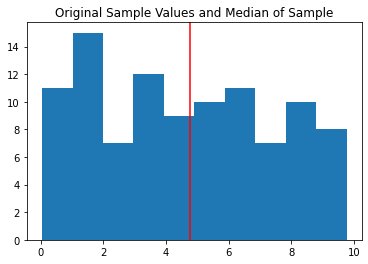

In [6]:
fig, ax = plt.subplots()

ax.hist(data)
ax.axvline(np.median(data), color = 'red')
ax.set_title('Original Sample Values and Median of Sample');

Notice the median of this sample is just a single value. It is probably *close to*, but surely not *precisely* the median of the population from which this sample was drawn.

The true median of the population is within some range around this estimate of the median.

What's the confidence interval of this estimate?

We can bootstrap samples from our sample data to make an estimate of the population.


In [7]:
def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.))), medians

The 95.0% confidence interval of the median is from 3.343 to 5.534


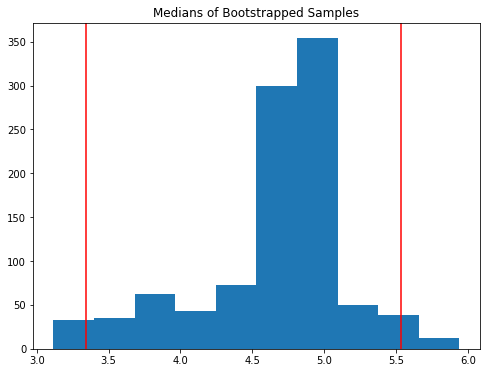

In [8]:
alpha = .05
ci = bootstrap_confidence_interval(data, np.median, alpha)

print(f"The {100-100*alpha}% confidence interval of the median is from {ci[0][0]:.3f} to {ci[0][1]:.3f}")

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(ci[1])
ax.axvline(ci[0][0], color = 'red')
ax.axvline(ci[0][1], color = 'red')
ax.set_title('Medians of Bootstrapped Samples');

Our procedure was
  * Take 1000 bootstrap samples from our original sample.
  * Take the median of each sample.
  * The 95% confidence inverval for the median is between the 25th and 975th largest samples.
 

### Other Bootstraps

We can bootstrap to get estimates of population parameters (median, mean, standard deviation, etc). 


**We can also bootstrap predictions.**


Remember: a "prediction" gives a single value. It's likely to be fairly close to the "ideal" prediction, but almost certainly not exactly equal to the ideal prediction. 

If we make several predictions, some are likely a bit high, others a bit low, the "ideal" prediction is somewhere in this range.

## Bootstrapped aggregation

 * We are thinking about the population of all possible decision tree models on our data.
 * If I take $n$ samples *iid* from this distribution and average them the variance goes down by $\sqrt n$
 * There is some correlation between models because they are all trained on bootstrap samples from the same draw.

## An Experiment

Let's make decision trees on bootstraped samples, and then we'll all ensemble the results.

In [9]:
data = load_iris()

# Split into test/train, using the same random state for everyone
X_train, X_test, y_train, y_test = train_test_split(data.data,
                                                    data.target,
                                                    random_state=462)

In [10]:
bootstrap_sample1 = np.random.choice(range(len(X_train)), len(X_train), replace=True)
bootstrap_sample2 = np.random.choice(range(len(X_train)), len(X_train), replace=True)
bootstrap_sample3 = np.random.choice(range(len(X_train)), len(X_train), replace=True)

clf1 = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()
clf3 = DecisionTreeClassifier()

clf1.fit(X_train[bootstrap_sample1], y_train[bootstrap_sample1])
clf2.fit(X_train[bootstrap_sample2], y_train[bootstrap_sample2])
clf3.fit(X_train[bootstrap_sample3], y_train[bootstrap_sample3]);

In [11]:
print(["Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)) for clf in [clf1, clf2, clf3]])

['Accuracy = 0.947', 'Accuracy = 0.816', 'Accuracy = 0.868']


In [12]:
for i, clf in enumerate([clf1, clf2,  clf3]):
    
    print(f"Prediction {i} : {clf.predict(X_test)[0:20]}")
print()
print("Actual target: {}".format(y_test[0:20]))

Prediction 0 : [0 2 0 1 1 1 2 2 0 2 2 0 1 2 2 2 1 2 1 0]
Prediction 1 : [0 2 0 1 2 2 2 2 0 2 2 0 2 2 1 2 1 2 1 0]
Prediction 2 : [0 2 0 2 2 1 2 2 0 2 2 0 2 2 2 1 1 2 1 0]

Actual target: [0 2 0 1 2 1 2 2 0 2 2 0 1 2 2 2 1 2 1 0]


We see that each predictor is wrong once or twice.  But generally, the consensus is right nearly all the time.

## Bagging

This concept, creating each model from a bootstrap sample and aggregating the results, is called **bagging**.

(**Bagging** is short for **Bootstrap** -- **Aggregating**)

It could be used with any sort of model, but is generally done with decision trees.

**Question:** why?

<details><summary>CLICK ME</summary>

#### Answer:

Models that consider all features at once are harder to de-correlate. Decision trees consider features individually (and independently), so their response to various features changes more as the data changes.


</details>

### Bootstraping on Regression Trees

Let's do another example. Consider some points with one feature ($x$) and a numeric target ($y$).

In [13]:
n_data = 5000
x = stats.uniform(0, 8).rvs(n_data)
y = np.sin(x/2)+2*np.cos(2*x) + stats.norm(0, 1.5).rvs(n_data)

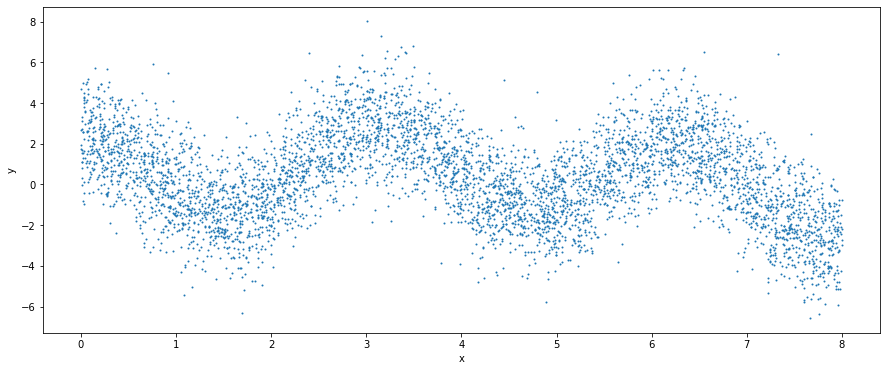

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
ax.set_xlabel('x')
ax.set_ylabel('y');

We'll create a decision tree to predict the points. We won't make it that deep because we want to visualize the prediction.

In [15]:
max_depth = 9
model = DecisionTreeRegressor(max_depth=max_depth)
model.fit(x.reshape(-1, 1), y)

DecisionTreeRegressor(max_depth=9)

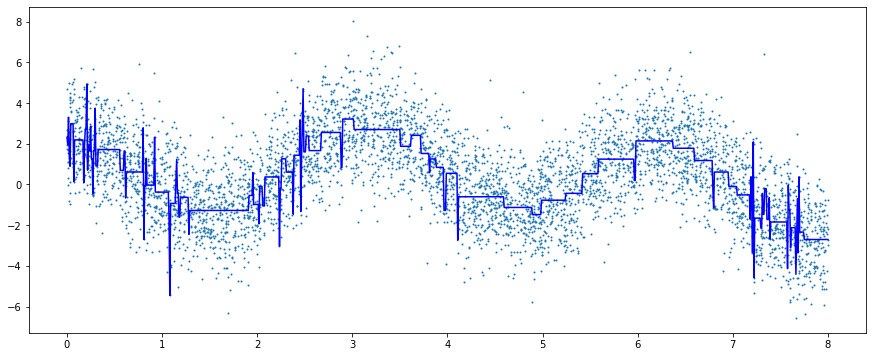

In [16]:
n_pts = 1000
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
xpts = np.linspace(x.min(), x.max(), n_pts)
p1 = ax.plot(xpts, model.predict(xpts.reshape(-1, 1)), 'b')

That's what one decision tree looks like; each discontinuity is a node split. Notice that there is fairly high variance.

What if we create a bunch of bootstrap samples and build an ensemble of trees from them?

In [17]:
n_bootstraps = 1000
yptses = np.zeros((n_bootstraps, n_pts))
for i in range(n_bootstraps):
    bootstrap = np.random.choice(np.arange(n_data), n_data, True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x[bootstrap].reshape(-1, 1), y[bootstrap])
    yptses[i] = model.predict(xpts.reshape(-1, 1))

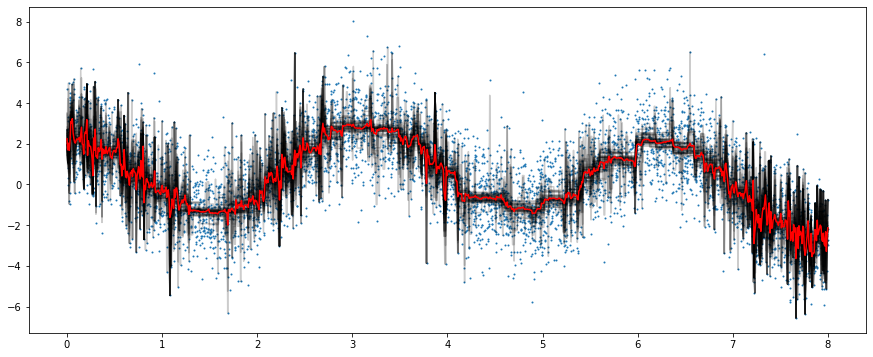

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
for i in range(yptses.shape[0]//25):
    ax.plot(xpts, yptses[i], alpha = .2, color = 'black')
ax.plot(xpts, yptses.mean(axis=0), 'r');

Observe that some individual tress (black lines) are erratic (over-fit to particular noisy points).

But, when averaged together (red), it is substantially less erratic.

We have improved **variance** without sacraficing **bias**.

Remember:  **Bagging** works by injecting an element of randomness into the training data.  
    
But, after the training data is chosen, all the trees are built according to the same algorithm.

## Bagging $\longrightarrow$ Random Forests

Bagging decision trees are pretty cool, but the trees still tend to look pretty similar. 

You can only bootstrap samples so many times before they start to resemble each other.

We want a way to make the trees more different (decorrelate them) without substantially increasing the bias of each tree.

Random forests do this with **subspace sampling**. **Space** refers to the set of *features*, so *subspace* means "a set of features that does not include all of the features."

When we are building a tree and considering the feature to use at each split, we only consider a few features, randomly chosen. 

The number of features $m$ to consider at each split is a hyperparameter; typically $m = \sqrt k$ is used.

The features to consider are chosen **at each split**, not each tree. **Everyone gets this wrong.**

**Question:** are features to consider chosen for each tree, or at each split?

For example, suppose we're building a model with nine features. One of them is really predictive, another is pretty good, and the others are just okay.

If we build an ensemble of bagged trees (without subpace), probably each will use the good feature as the first split, and probably each will use the pretty-good feature at the next split. For the other splits the trees might differ, particularly father down when only a few points are being considered, but the first branches will be pretty much the same.

Even though all the trees are seeing different training data, they're pretty much going to use the same set of splits, or at least, *correlated* splits.

If we build trees in a random forest (with bootstrap samping *and* feature subspace), we'll only consider three (random) features for that first split. Only a fraction of the trees (around 33%) will consider the good feature on the first split, so they will use that. Some of the others will consider the pretty-good feature, so they will start there. The others will start at some other feature. Those trees will still consider the good and pretty-good features at some of the lower nodes, and will get to take advantage of them, but the overall structure of those trees will be completely different.

#### Difference between Bagging and Random Forest:
* Bagging injects randomness in the selection of training data
* Random Forest uses randomness in both the training data *and* the features considered at each split

**More randomness $\longrightarrow$ more decorrelation**

## Random Forest Parameters

Random Forest Parameters

 * Total number of trees
 * Number of features to use at each split
 * Individual decision tree Parameters
    - e.g., tree depth, pruning, split criterion

In general, Random Forests are fairly robust to the choice of parameters and overfitting.

## Pros and Cons of Random Forest

Pros

 * Often give near state-of-the-art performance
 * Good out-of-the-box performance
 * No feature scaling needed
 * Model nonlinear relationships

Cons

 * Can be expensive to train (though can be done in parallel)
 * Not interpretable

## Comparison to Decision Trees

Let's investigate the accuracy of a random forests compared with a single decision tree using the Breast Cancer Classification dataset. 

In [19]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X = X.drop(['worst concave points', 'mean concave points', 'worst perimeter', 'worst radius', 'worst area', 'mean concavity'], axis=1)

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)


First, consider a decision tree, doing a grid search over hyperparameters.

test accuracy = 0.899


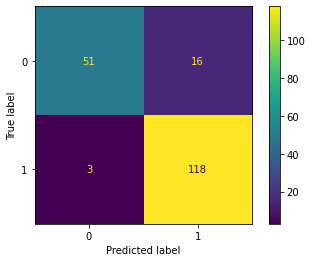

In [20]:
# Parameter Search                                     
model = DecisionTreeClassifier()

# depth_parm = 
# num_samples_parm = np.arange(5,95,10)

parameters = {'max_depth' : np.arange(1, 12),
             'min_samples_leaf' : np.arange(5,95,10)}

scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)

clf = GridSearchCV(model,
                   parameters,
                   cv=10,
                   scoring=scorer).fit(X_train,y_train)

print(f"test accuracy = {(clf.predict(X_test) == y_test).mean():.3f}")

cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

In [21]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=65)

In [22]:
clf.best_params_

{'max_depth': 8, 'min_samples_leaf': 65}

### Now random forests.

accuracy = 0.952


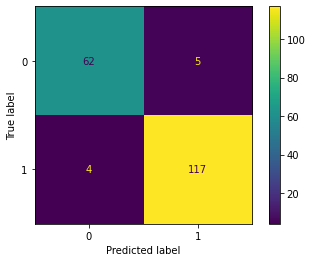

In [23]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

print(f"accuracy = {rf.score(X_test, y_test):.3f}")

cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

So that's better.

### Question:  Why can't we use Random Forest on the sine-wave regressor shown above?

<details><summary>CLICK ME</summary>

#### Answer:

The sine-wave regressor has only one feature (the X-value), so we can't select a subset of features at each split


</details>